In [1]:
import warnings
warnings.filterwarnings('ignore')

import re
import string
import os
from collections import defaultdict
from collections import Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# General science/numeric tools
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc,f1_score

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# NLTK for NLP tools such as stemming, lemmatizing
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('punkt')
nltk.download('wordnet')
stop = set(stopwords.words('english'))

from sklearn.feature_extraction.text import CountVectorizer

import gensim
from tqdm.notebook import tqdm

import torch
import random
from torchtext import datasets
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader,Sampler
from torch.nn.utils.rnn import pad_sequence

import matplotlib.pyplot as plt
import torch
from torchtext import data
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import spacy
from torchdata.datapipes.iter import FileOpener, IterableWrapper, CSVParser
import os
from torch import nn
from torch.nn import functional as F

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
# to access my drive to read the csv-files
from google.colab import drive
drive.mount('/content/drive')

# link to the folder of Colab Notebooks 
%cd '/content/drive/MyDrive/Colab Notebooks'

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


In [3]:
df = pd.read_csv('train_bodies.csv')
df1 = pd.read_csv('train_stances.csv')

df_merge = pd.merge(df, df1, on='Body ID')

TEXT_C = ['articleBody','Headline']
TARGET_C = 'Stance'

df_merge['Stance'].replace(['agree', 'disagree', 'discuss'], 'related',inplace=True)
print(df_merge['Stance'].value_counts())
# print(train_text.isna().sum())

unrelated    36545
related      13427
Name: Stance, dtype: int64


In [4]:
len(df_merge)

49972

In [5]:
#drop Body ID 
df_merge.drop("Body ID", axis=1, inplace=True)

# Split data into train and temporary sets with an 80:20 split ratio
train, test = train_test_split(df_merge.head(10000), test_size=0.2, random_state=42)

# Split the temporary set into validation and test sets with a 50:50 split ratio
val, test = train_test_split(test, test_size=0.5, random_state=42)


In [6]:
# Extract the text data and target data for each set
train_text, train_target = train[TEXT_C], train[TARGET_C]
val_text, val_target = val[TEXT_C], val[TARGET_C]
test_text, test_target = test[TEXT_C], test[TARGET_C]
print('Size of training set:',train.shape)
print('Size of validation set:',val.shape)
print('Size of validation set:',test.shape)
print(type(train_target))

Size of training set: (8000, 3)
Size of validation set: (1000, 3)
Size of validation set: (1000, 3)
<class 'pandas.core.series.Series'>


In [7]:
# Convert the target data to numerical values
train = train.replace({'unrelated': 0, 'related': 1})
val = val.replace({'unrelated': 0, 'related': 1})
test = test.replace({'unrelated': 0, 'related': 1})

train_target = train_target.replace({'unrelated': 0, 'related': 1})
val_target = val_target.replace({'unrelated': 0, 'related': 1})
test_target = test_target.replace({'unrelated': 0, 'related': 1})

#build a new target-series data for BERT-model (prevent that the original data is changed)
train_target_1 = train_target
val_target_1 = val_target
test_target_1 = test_target

train_text_1 = train_text
val_text_1 = val_text
test_text_1 = test_text

TF-IDF

In [8]:
# import re
# from nltk.corpus import stopwords
# from sklearn.feature_extraction.text import TfidfVectorizer

# Define a preprocessing function
def preprocess(text):
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    tokens = [token for token in tokens if token.lower() not in stop_words]
    # Convert tokens back to text
    text = ' '.join(tokens)
    return text

In [9]:
# train_data = train_text
# train_data
# change the dataframe with two columns to a column to be used in tfidf function
combined_train_series = (train_text['articleBody']+train_text['Headline']).apply(preprocess)
combined_val_series = (val_text['articleBody']+val_text['Headline']).apply(preprocess)
combined_test_series = (test_text['articleBody']+test_text['Headline']).apply(preprocess)


In [10]:
# Convert the text data to numerical data

# Use TF-IDF to convert the text data to feature vectors
tfidf = TfidfVectorizer(decode_error='ignore', lowercase=True, min_df=2)
# can set up max_df=0.8/0.9 to avoid the intervention of the most common words
train_features = tfidf.fit_transform(combined_train_series.values.astype('U'))
val_features = tfidf.transform(combined_val_series.values.astype('U'))
test_features = tfidf.transform(combined_test_series.values.astype('U'))

In [11]:
print('Size of training set:',train_features.shape)
print('Size of validation set:',val_features.shape)
print('Size of validation set:',test_features.shape)

Size of training set: (8000, 13615)
Size of validation set: (1000, 13615)
Size of validation set: (1000, 13615)


In [12]:
# # Convert the target data to numerical values
# train_target = train_target.replace({'unrelated': 0, 'related': 1})
# val_target = val_target.replace({'unrelated': 0, 'related': 1})
# test_target = test_target.replace({'unrelated': 0, 'related': 1})

# # train = train.replace({'unrelated': 0, 'related': 1})
# # val = val.replace({'unrelated': 0, 'related': 1})
# # test = test.replace({'unrelated': 0, 'related': 1})

# #build a new target-series data for BERT-model (prevent that the original data is changed)
# train_target_1 = train_target
# val_target_1 = val_target
# test_target_1 = test_target

# train_text_1 = train_text
# val_text_1 = val_text
# test_text_1 = test_text

BERT

In [24]:
# import locale
# locale.getpreferredencoding = lambda: "UTF-8"

In [13]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 89.5 MB/s eta 0:00:00


In [14]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [15]:
init_token = tokenizer.cls_token
eos_token = tokenizer.sep_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token
init_token_idx = tokenizer.cls_token_id
eos_token_idx = tokenizer.sep_token_id
pad_token_idx = tokenizer.pad_token_id
unk_token_idx = tokenizer.unk_token_id

print(init_token, eos_token, pad_token, unk_token)


[CLS] [SEP] [PAD] [UNK]


In [16]:
max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']

def tokenize_and_cut(sentence):
    tokens = tokenizer.tokenize(sentence) 
    tokens = tokens[:max_input_length-2]
    return tokens



In [17]:
# import torch
# import random
# from torchtext import datasets
# from torchtext.data.functional import to_map_style_dataset

train_dataset  = to_map_style_dataset(train.values)
# y_train_dataset = to_map_style_dataset(y_train_2)
val_dataset  = to_map_style_dataset(val.values)
# y_val_dataset = to_map_style_dataset(y_val_2)
test_dataset   = to_map_style_dataset(test.values)
# y_test_dataset = to_map_style_dataset(y_test_2)

train_dataset = list(train_dataset)
val_dataset = list(val_dataset)
test_dataset = list(test_dataset)

In [18]:
# from torch.utils.data import DataLoader,Sampler
# from torch.nn.utils.rnn import pad_sequence

BATCH_SIZE = 32


# integrate headline and articlebody in this step
def vectorize_batch(batch):
    '''Take a batch of (text,label) pairs and return tensors ready for input to the model.'''
    label_list, text_list = [], []
    # train_dataset_c[0]['Headline'][0]    
    for (headline, body,stance) in batch:
    # for item in batch:
    #   headline, body, stance, *_ = item  # unpack only the first 3 values of the tuple
      # Use a for loop to iterate over each row in the dataframe
      # for i in range (len(X_train_bert)):
        # Add the new string to the new_column_values list
      label_list.append(int(stance))
      tokens = tokenizer.convert_tokens_to_ids(tokenize_and_cut(headline))
      tokens1 = tokenizer.convert_tokens_to_ids(tokenize_and_cut(body))
      tokens1 = tokens1[0:max_input_length]
      text_list.append(torch.tensor(tokens))
      # print(text_list)
    return pad_sequence(text_list,
                        padding_value=pad_token_idx,
                        batch_first=True), torch.tensor(label_list)
                                      
class BucketSampler(Sampler):
    def __init__(self, dataset, batch_size):
        # train_list = list(dataset)
        indices = [(i, len(tokenizer(s[0]))) for i, s in enumerate(dataset)]
        random.shuffle(indices)
        self.batch_size = batch_size
        
        # create pool of indices with similar lengths 
        self.pooled_indices = []
        for i in range(0, len(indices), self.batch_size * 100):
            self.pooled_indices.extend(sorted(indices[i:i + self.batch_size * 100], key=lambda x: x[1]))
        self.pooled_indices = [x[0] for x in self.pooled_indices]
        
    def __iter__(self):
        self.count = 0
        return self
    
    def __next__(self):
        # yield indices for current batch
        if self.count >= len(self.pooled_indices)-self.batch_size:
            raise StopIteration
        self.count += 1
        
        for i in range(0, len(self.pooled_indices), self.batch_size):
            return self.pooled_indices[self.count:self.count + self.batch_size]
        
    def __len__(self):
        return len(self.pooled_indices)


train_iterator  = DataLoader(train_dataset, collate_fn=vectorize_batch, batch_size=BATCH_SIZE)
val_iterator  = DataLoader(val_dataset, collate_fn=vectorize_batch, batch_size=BATCH_SIZE)
test_iterator   = DataLoader(test_dataset,  collate_fn=vectorize_batch, batch_size=BATCH_SIZE)


In [19]:
# for x,y in val_iterator:
#   print(y)

In [20]:
# train_iterator
# len(train_iterator)

In [21]:
train_text_bert = []
train_target_bert = []

for i, (train_text_1, train_target_1) in enumerate(train_iterator):
    for e in train_text_1.tolist():
      train_text_bert.append(e)
    for e in train_target_1.tolist():
      train_target_bert.append(e)

val_text_bert = []
val_target_bert = []

for i, (val_text_1, val_target_1) in enumerate(val_iterator):
    for e in val_text_1.tolist():
      val_text_bert.append(e)
    for e in val_target_1.tolist():
      val_target_bert.append(e)

test_text_bert = []
test_target_bert = []

for i, (test_text_1, test_target_1) in enumerate(test_iterator):
    for e in test_text_1.tolist():
      test_text_bert.append(e)
    for e in test_target_1.tolist():
      test_target_bert.append(e)

Build the Naive Bayes for TF-IDF

In [34]:
#Import the liberary
import seaborn as sn
%matplotlib inline
from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc,f1_score

In [35]:
# Create the confusion matrix
def plot_confusion_matrix(y_test, y_pred):
    ''' Plot the confusion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confusion matrix values
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))

    # Plot the confusion matrix
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True,fmt='.0f',cmap="YlGnBu",annot_kws={"size": 10}) # font size
    plt.show()

def plot_roc_curve(y_test, y_pred):
    ''' Plot the ROC curve for the target labels and predictions'''
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc= auc(fpr,tpr)
    plt.figure(figsize=(12, 12))
    ax = plt.subplot(121)
    ax.set_aspect(1)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [42]:
# create the model, train it on the train dataset and print the scores
from sklearn.naive_bayes import GaussianNB

model = GaussianNB() #MultinomialNB() #GaussianNB()
model.fit(train_features.toarray(), train_target)
print("Train score:", model.score(train_features.toarray(), train_target))
# print("Validation score:", model.score(val_features.toarray(), val_target))
print("Test score:", model.score(test_features.toarray(), test_target))

Train score: 0.8755
Test score: 0.825


              precision    recall  f1-score   support

           0       0.95      0.84      0.90       895
           1       0.33      0.66      0.44       105

    accuracy                           0.82      1000
   macro avg       0.64      0.75      0.67      1000
weighted avg       0.89      0.82      0.85      1000



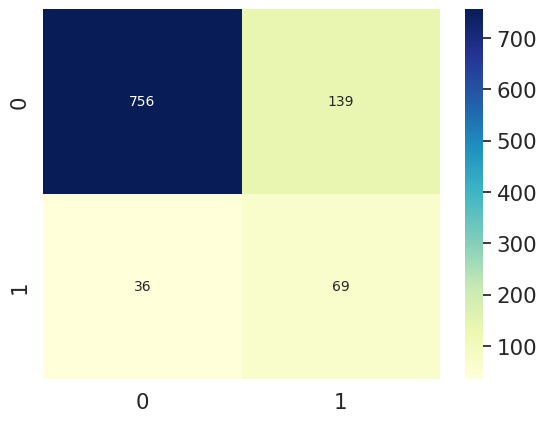

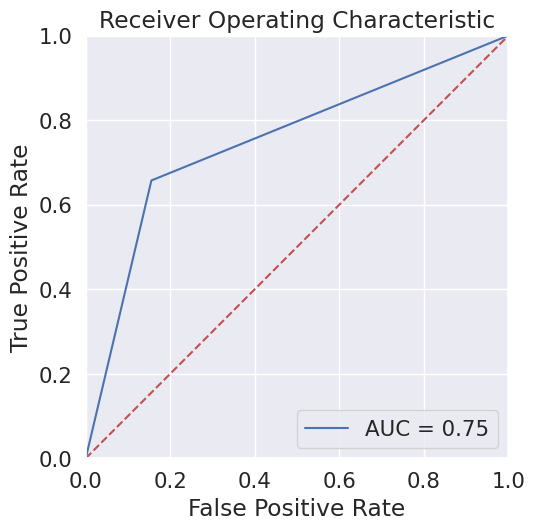

In [37]:
y_pred = model.predict(test_features.toarray())
#print the classification report to highlight the accuracy with f1-score, precision and recall

print(metrics.classification_report(test_target, y_pred))
plot_confusion_matrix(test_target, y_pred)
plot_roc_curve(test_target, y_pred)

In [38]:
print(type(test_text_bert))

<class 'list'>


Build the Bayes model on BERT-Model

In [40]:
# create the model, train it on the train dataset and print the scores
model = GaussianNB() #MultinomialNB()  #GaussianNB()
model.fit(train_text_bert, train_target_bert)
print("Train score:", model.score(train_text_bert, train_target_bert))
# print("Validation score:", model.score(val_text_bert, val_target_bert))
print("Test score:", model.score(test_text_bert, test_target_bert))

Train score: 0.773875
Test score: 0.773


              precision    recall  f1-score   support

           0       0.93      0.81      0.86       895
           1       0.23      0.50      0.31       105

    accuracy                           0.77      1000
   macro avg       0.58      0.65      0.59      1000
weighted avg       0.86      0.77      0.81      1000



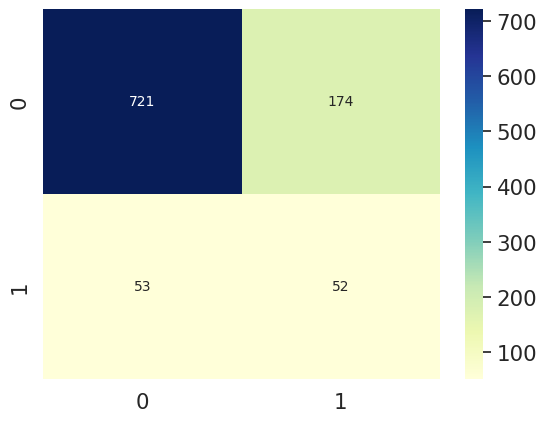

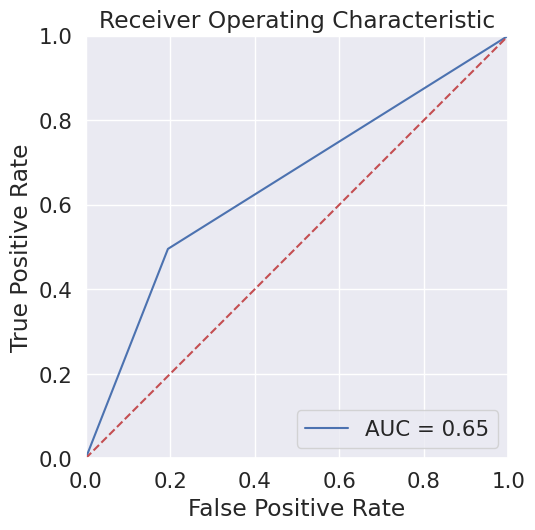

In [41]:
y_pred = model.predict(test_text_bert)
#print the classification report to highlight the accuracy with f1-score, precision and recall

print(metrics.classification_report(test_target_bert, y_pred))
plot_confusion_matrix(test_target_bert, y_pred)
plot_roc_curve(test_target_bert, y_pred)

LSTM model for TF-IDF

In [22]:
import matplotlib.pyplot as plt
import torch
from torchtext import data
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import spacy
from torchdata.datapipes.iter import FileOpener, IterableWrapper, CSVParser
import os
from torch import nn
from torch.nn import functional as F

In [23]:
vocab = tfidf.get_feature_names_out()
len(vocab)

13615

In [24]:
# vocab = tfidf.get_feature_names_out()
# len(vocab)

class TEXT_LSTM(nn.Module):
    def __init__(self, dimension=64):
        super(TEXT_LSTM, self).__init__()
        self.embedding_layer = nn.Embedding(len(vocab), 300)
        self.rnn = nn.LSTM(
            input_size=300,
            hidden_size=dimension,
            num_layers=1,
            bidirectional=True,
            batch_first=True)
        self.drop = nn.Dropout(p=0.5)
        self.fc = nn.Linear(2*dimension, 1)

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        # print(1)
        # print(embeddings)
        # print(embeddings.shape)
        output, hidden = self.rnn(embeddings)
        # print(2)
        # print(output)     
        # print(output.shape) 
        # text_fea = self.drop(output[:,-1])
        text_fea = self.drop(output)
        # print(3)
        # print(text_fea)
        # print(type(text_fea))
        # print(text_fea.shape)

        text_fea = self.fc(text_fea)
        # print(4)
        text_fea = torch.squeeze(text_fea,1)
        # print(5)
        text_out = torch.sigmoid(text_fea)
        # print(6)
        return text_out

    
# Print out the layers
model = TEXT_LSTM()
print("Layers:")
for layer in model.children():
    print("\t{}".format(layer))

Layers:
	Embedding(13615, 300)
	LSTM(300, 64, batch_first=True, bidirectional=True)
	Dropout(p=0.5, inplace=False)
	Linear(in_features=128, out_features=1, bias=True)


In [25]:
def save_checkpoint(save_path,model,optimizer,valid_loss):
    if save_path == None:
        return
    state_dict ={'model_state_dict': model.state_dict(),
                 'optimizer_state_dict': optimizer.state_dict(),
                 'valid_loss': valid_loss}
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')
    
def load_checkpoint(load_path,model,optimizer):
    if load_path == None:
        return
    state_dict = torch.load(load_path)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']

def save_metrics(save_path,train_loss_list, valid_loss_list,global_steps_list):
    if save_path==None:
        return
    state_dict= {'train_loss_list': train_loss_list,
                 'valid_loss_list': valid_loss_list,
                 'global_steps_list': global_steps_list}
    torch.save(state_dict, save_path)
    print(f'Metrics saved to ==> {save_path}')
# def save_metrics(train_loss_list, valid_loss_list, global_steps_list):
#     metrics = {
#         'train_loss_list': train_loss_list,
#         'valid_loss_list': valid_loss_list,
#         'global_steps_list': global_steps_list
#     }
#     return metrics

    
def load_metrics(load_path):
    if load_path == None:
        return 
    state_dict = torch.load(load_path)
    print(f'Metrics loaded from <== {load_path}')
    return state_dict['train_loss_list'],state_dict['valid_loss_list'],state_dict['global_steps_list']

In [26]:
train_loader_s = zip(train_features,train_target)
val_loader_s = zip(val_features,val_target)
test_loader = zip(test_features, test_target)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
def train(model,
          optimizer,):
  
    criterion = nn.BCELoss()
    num_epochs = int(5)
    eval_every = train_features.shape[0] // 2
    file_path = "output"
    best_valid_loss = float("Inf")
    # Initial running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list=[]
    valid_loss_list = []
    global_steps_list = []
    # Training Loop
    model.train()
    for epoch in range(num_epochs):
        # print(epoch)
        losses = []
        for text, labels in zip(train_features,train_target):
            # print(train_loader_tf)
            # print(text)
            # print(global_step)
            # print(eval_every)
            # Move everything to the right device
            # text = text.toarray()
            text = torch.tensor(text.shape[0])
            labels = torch.tensor(labels)
            text   = text.unsqueeze(-1).to(device)
            labels = labels.to(device)
            
            # Forward pass
            output = model(text.long())
            # print(output.size())
            # print(labels.size())
            # Calculate loss

            loss = criterion(output, labels.float().view(-1,1).squeeze(0))
            # output.to(torch.float32), labels.to(torch.float32)
            # loss = criterion(output.to(torch.float32), labels.to(torch.float32))
            losses.append(loss.item())

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update running values
            running_loss += loss.item()
            global_step  += 1
            # print(global_step)
            # print(eval_every)
            # Evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():
                    # Validation loop
                    valid_losses = []
                    for text, labels in zip(val_features,val_target):
                        text = torch.tensor(text.shape[0])
                        labels = torch.tensor(labels)
                        text   = text.unsqueeze(-1).to(device)
                        labels = labels.to(device)
                        output = model(text.long())
                        loss = criterion(output, labels.float().view(-1,1).squeeze(0))
                        valid_losses.append(loss.item())
                        # loss = criterion(output.to(torch.float32), labels.to(torch.float32))
                        valid_running_loss += loss.item()
                    
                # Evaluation
                average_train_loss = running_loss/eval_every
                average_valid_loss = valid_running_loss/len(text) #valid_loader
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # Resetting running values
                running_loss = 0.0
                valid_running_loss = 0.0
                model.train()
                # print(epoch)
                print('Epoch[{}/{}], Step [{}/{}], Train loss:{:.4f}, Valid loss:{:.4f}'.format(
                epoch+1, num_epochs, global_step, num_epochs*len(text),average_train_loss,
                    average_valid_loss))

                # Checkpoint

                # if best_valid_loss > average_valid_loss:
                best_valid_loss = average_valid_loss
                save_checkpoint(file_path+'/model.pt', model, optimizer, best_valid_loss)
                save_metrics(file_path+'/model.pt',train_loss_list,valid_loss_list,global_steps_list)
                    # file_path+'/model.pt'
          # metrics = save_metrics(file_path+'/model.pt',train_loss_list,valid_loss_list,global_steps_list)
          # print('Training is Done!')
    # double-check whether any data is in these three elements 
          # 
    # file_path+'/metrics.pt',
    print('Epoch {} done'.format(epoch+1))

    metrics = save_metrics("output"+'/model.pt',train_loss_list,valid_loss_list,global_steps_list)
    print('Training is Done!')
    return train_loss_list,valid_loss_list,global_steps_list
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model = model.to(device)
train_loss_list,valid_loss_list,global_steps_list = train(model, optimizer) #, file_path=destination_folder
# file_path="output"

Epoch[1/5], Step [4000/5], Train loss:0.3345, Valid loss:304.9929
Model saved to ==> output/model.pt
Metrics saved to ==> output/model.pt
Epoch[1/5], Step [8000/5], Train loss:0.3513, Valid loss:305.9491
Model saved to ==> output/model.pt
Metrics saved to ==> output/model.pt
Epoch[2/5], Step [12000/5], Train loss:0.3302, Valid loss:304.8455
Model saved to ==> output/model.pt
Metrics saved to ==> output/model.pt
Epoch[2/5], Step [16000/5], Train loss:0.3512, Valid loss:306.5671
Model saved to ==> output/model.pt
Metrics saved to ==> output/model.pt
Epoch[3/5], Step [20000/5], Train loss:0.3306, Valid loss:305.3224
Model saved to ==> output/model.pt
Metrics saved to ==> output/model.pt
Epoch[3/5], Step [24000/5], Train loss:0.3535, Valid loss:306.5450
Model saved to ==> output/model.pt
Metrics saved to ==> output/model.pt
Epoch[4/5], Step [28000/5], Train loss:0.3302, Valid loss:304.8533
Model saved to ==> output/model.pt
Metrics saved to ==> output/model.pt
Epoch[4/5], Step [32000/5], T

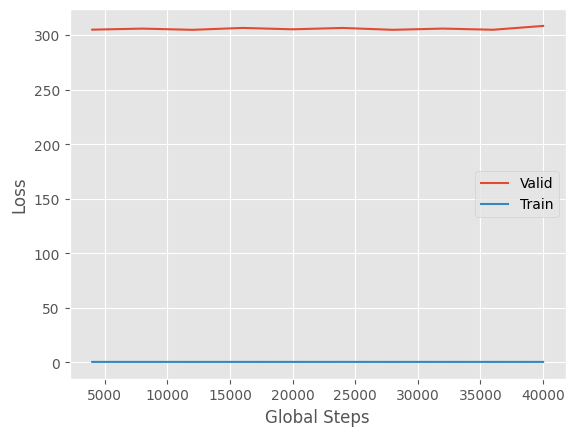

In [28]:
# Examine model training
# metrics = save_metrics("output/model.pt",train_loss_list, valid_loss_list, global_steps_list)
# train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder+'/metrics.pt')

# metrics = save_metrics(file_path+'/model.pt',train_loss_list, valid_loss_list, global_steps_list)

plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plt.plot(metrics['global_steps_list'], metrics['train_loss_list'], label='Train')

Evaluation

In [29]:
def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []
    model.eval()
    with torch.no_grad():
        for text, labels in test_loader:
            # text = text.to(device)
            # labels = labels.to(device)
            # output = model(text.long())
            # output = (output > threshold).int()
            # y_pred.extend(output.tolist())
            # y_true.extend(labels.cpu().tolist())
                                  
            
            text = torch.tensor(text.shape[0])
            labels = torch.tensor(labels)
            text   = text.unsqueeze(-1).to(device) #device
            labels = labels.to(device) #device
            output = model(text.long())

            output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_true.append(labels)



            # text = torch.tensor(text.shape[0])
            #             labels = torch.tensor(labels)
            #             text   = text.unsqueeze(-1).to(device)
            #             labels = labels.to(device)
            #             output = model(text.long())
            # print(labels)
            # labels = labels.to(device)
            # text   = text.unsqueeze(-1).to(device)
            # text = text.to(device)
            #text_len = text_len.to(device)
            # output = model(text.long()).numpy()
            
            # y_true = [label.item() for label in labels]

            # y_true.append(labels)
            
            # y_true.extend(labels.tolist())
            
    
    print('Classification Report:')
    print(classification_report(y_true,y_pred,labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true,y_pred,labels=[1,0])
    ax = plt.subplot()
    sns.heatmap(cm,annot=True, ax=ax,cmap='Blues',fmt='d')
    
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicated Labels')
    ax.set_ylabel('True Labels')
    
    ax.xaxis.set_ticklabels(['Real','Irrelevant'])
    ax.yaxis.set_ticklabels(['Real','Irrelevant'])

In [30]:
# print(y_pred())

In [31]:
# tensor_on_cpu = tensor_on_gpu.cpu()
# numpy_array = tensor_on_cpu.numpy()

Classification Report:
              precision    recall  f1-score   support

           1     0.1050    1.0000    0.1900       105
           0     0.0000    0.0000    0.0000       895

    accuracy                         0.1050      1000
   macro avg     0.0525    0.5000    0.0950      1000
weighted avg     0.0110    0.1050    0.0200      1000



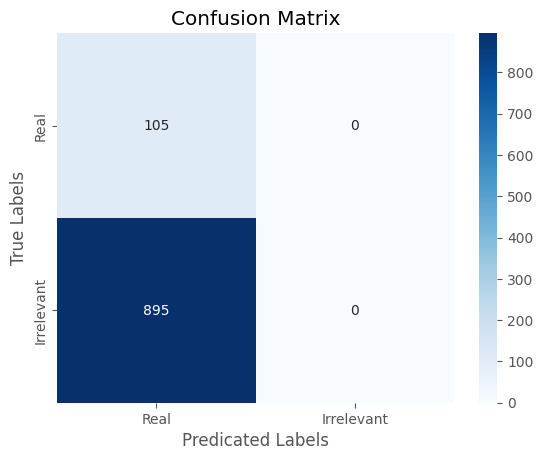

In [32]:
best_model = TEXT_LSTM().to(device)
optimizer = optim.Adam(best_model.parameters(), lr = 0.001)
# load_checkpoint(destination_folder+'/model.pt',best_model,optimizer)
evaluate(best_model, test_loader)

LSTM model for Bert

In [78]:
# vocab_bert = tfidf.get_feature_names_out()
# len(vocab)

# from transformers import BertTokenizer

# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_bert = tokenizer.get_vocab()
len(vocab_bert)

30522

In [79]:
# vocab = tfidf.get_feature_names_out()
# len(vocab)

class TEXT_LSTM(nn.Module):
    def __init__(self, dimension=64):
        super(TEXT_LSTM, self).__init__()
        self.embedding_layer = nn.Embedding(len(vocab_bert), 300)
        self.rnn = nn.LSTM(
            input_size=300,
            hidden_size=dimension,
            num_layers=1,
            bidirectional=True,
            batch_first=True)
        self.drop = nn.Dropout(p=0.5)
        self.fc = nn.Linear(2*dimension, 2)

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        output, hidden = self.rnn(embeddings)
        text_fea = self.drop(output[:,-1])
        # text_fea = self.drop(output)
        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea,1)
        # text_fea = torch.squeeze(text_fea)
        text_out = torch.sigmoid(text_fea)
        return text_out

    
# Print out the layers
model = TEXT_LSTM()
print("Layers:")
for layer in model.children():
    print("\t{}".format(layer))

Layers:
	Embedding(30522, 300)
	LSTM(300, 64, batch_first=True, bidirectional=True)
	Dropout(p=0.5, inplace=False)
	Linear(in_features=128, out_features=2, bias=True)


In [80]:
def save_checkpoint(save_path,model,optimizer,valid_loss):
    if save_path == None:
        return
    state_dict ={'model_state_dict': model.state_dict(),
                 'optimizer_state_dict': optimizer.state_dict(),
                 'valid_loss': valid_loss}
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')
    
def load_checkpoint(load_path,model,optimizer):
    if load_path == None:
        return
    state_dict = torch.load(load_path)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']

def save_metrics(save_path,train_loss_list, valid_loss_list,global_steps_list):
    if save_path==None:
        return
    state_dict= {'train_loss_list': train_loss_list,
                 'valid_loss_list': valid_loss_list,
                 'global_steps_list': global_steps_list}
    torch.save(state_dict, save_path)
    print(f'Metrics saved to ==> {save_path}')
# def save_metrics(train_loss_list, valid_loss_list, global_steps_list):
#     metrics = {
#         'train_loss_list': train_loss_list,
#         'valid_loss_list': valid_loss_list,
#         'global_steps_list': global_steps_list
#     }
#     return metrics

    
def load_metrics(load_path):
    if load_path == None:
        return 
    state_dict = torch.load(load_path)
    print(f'Metrics loaded from <== {load_path}')
    return state_dict['train_loss_list'],state_dict['valid_loss_list'],state_dict['global_steps_list']

In [81]:
# # train_loader = zip(train_text_bert,train_target_bert)
# # val_loader = zip(val_text_bert,val_target_bert)
# # test_loader = zip(test_text_bert, test_target_bert)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
len(train_dataset) // 2
# len(train_iterator) //3

4000

In [83]:
def train(model,
          optimizer,):
    criterion = nn.CrossEntropyLoss()
    train_loader_bert = train_iterator
    valid_loader_bert = val_iterator
    num_epochs = 5
    eval_every = 1#len(train_dataset) // 2
    file_path = "output"
    best_valid_loss = float("Inf")
    
    # Initial running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list=[]
    valid_loss_list = []
    global_steps_list = []
    # Training Loop
    model.train()
    for epoch in range(num_epochs):
        losses = []
        for text, labels in train_loader_bert:
            # print(text)
            # print(global_step)
            # print(eval_every)
            # Move everything to the right device
            # text = text.toarray()

            text = torch.tensor(text) #.shape[0] ##
            labels = torch.tensor(labels) ##


            text   = text.to(device)
            labels = labels.to(device)
            
            # Forward pass
            output = model(text)
            # print(output.size())
            # print(labels.size())
            # Calculate loss
            # output = torch.argmax(output, dim=1)
            output = torch.squeeze(output)
            # labels = torch.nn.functional.one_hot(labels)
            labels = (labels - labels.min()).long()
            labels = F.one_hot(labels, num_classes=2)
            labels = labels.float()

            # print(labels.size())
            loss = criterion(output, labels)
            # loss = criterion(output.to(torch.float32), labels.to(torch.float32))

            # output.to(torch.float32), labels.to(torch.float32)
            # loss = criterion(output.to(torch.float32), labels.to(torch.float32))
            losses.append(loss.item())

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update running values
            running_loss += loss.item()
            global_step  += 1
            # print(global_step)
            # print(eval_every)
            # Evaluation step
            if global_step % eval_every == 0:
                print('enter')
                model.eval()
                with torch.no_grad():
                    # Validation loop
                    valid_losses = []
                    for text, labels in valid_loader_bert:
                        # print(labels)
                        text = torch.tensor(text)
                        labels = torch.tensor(labels)
                        # text   = text.unsqueeze(-1).to(device)
                        labels = labels.to(device)
                        output = model(text.long())
                        # loss = criterion(output, labels)
                        loss = criterion(output, labels)
                        valid_losses.append(loss.item())
                        # loss = criterion(output.to(torch.float32), labels.to(torch.float32))
                        valid_running_loss += loss.item()

                        # text = torch.tensor(text)#.shape[0]
                        # labels = torch.tensor(labels)
                        # # text = text.to(device)
                        # text = text.to(device)
                        # labels = labels.to(device)
                        # print(text)
                        # output = model(text.long())#
                        # loss = criterion(output, labels)
                        # valid_losses.append(loss.item())
                        # # loss = criterion(output.to(torch.float32), labels.to(torch.float32))
                        # valid_running_loss += loss.item()
                    
                # Evaluation
                average_train_loss = running_loss/eval_every
                average_valid_loss = valid_running_loss/len(text) #valid_loader
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # Resetting running values
                running_loss = 0.0
                valid_running_loss = 0.0
                model.train()
                print(len(text))
                print(num_epochs*len(text))
                print('Epoch[{}/{}], Step [{}/{}], Train loss:{:.4f}, Valid loss:{:.4f}'.format(
                epoch+1, num_epochs, global_step, num_epochs*len(text),average_train_loss,
                    average_valid_loss))

                # Checkpoint

                # if best_valid_loss > average_valid_loss:
                best_valid_loss = average_valid_loss
                save_checkpoint(file_path+'/model.pt', model, optimizer, best_valid_loss)
                save_metrics(file_path+'/model.pt',train_loss_list,valid_loss_list,global_steps_list)
                    # file_path+'/model.pt'
    # metrics = save_metrics(file_path+'/model.pt',train_loss_list,valid_loss_list,global_steps_list)
    # print('Training is Done!')
    # # double-check whether any data is in these three elements 
    # return train_loss_list,valid_loss_list,global_steps_list
    # file_path+'/metrics.pt',
    print('Epoch {} done'.format(epoch+1))

    metrics = save_metrics("output"+'/model.pt',train_loss_list,valid_loss_list,global_steps_list)
    print('Training is Done!')
    return train_loss_list,valid_loss_list,global_steps_list
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model = model.to(device)
train_loss_list,valid_loss_list,global_steps_list = train(model, optimizer)#, num_epochs=5, train_loader_bert=train_iterator #, file_path=destination_folder
# file_path="output"

enter


RuntimeError: ignored

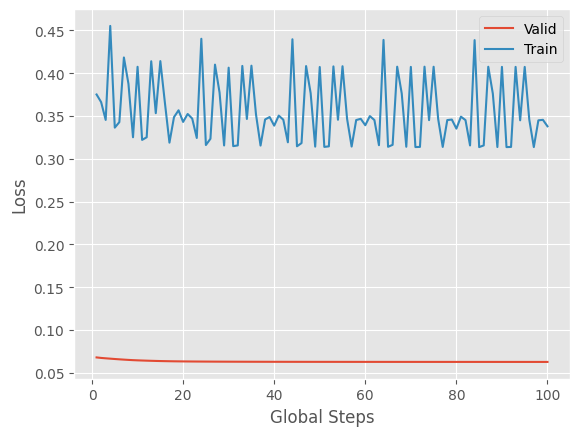

In [33]:
# train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder+'/metrics.pt')

plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

Evaluation


In [87]:
def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []
    model.eval()
    test_loader_bert = test_iterator
    with torch.no_grad():
        for text, labels in test_loader_bert:

            # text = torch.tensor(text.shape[0])
            #             labels = torch.tensor(labels)
            #             text   = text.unsqueeze(-1).to(device)
            #             labels = labels.to(device)
            #             output = model(text.long())
            # text = torch.tensor(text.shape[0])
            # labels = torch.tensor(labels)
            # text   = text.unsqueeze(-1).to(device)
            # labels = labels.to(device)

            text = torch.tensor(text)
            labels = torch.tensor(labels)
            # text   = text.unsqueeze(-1).to(device)
            labels = labels.to(device)
            output = model(text.long())
            # labels = labels.to(device)
            # text   = text.unsqueeze(-1).to(device)
            # text = text.to(device)
            #text_len = text_len.to(device)
            output = model(text.long())
            # output = torch.squeeze(output)
            # print(output)
            # print(output)
            # print(labels.shape)
            output = (output > threshold).int()
            output = output[:, 1] 
            # print(output)
            y_pred.extend(output.tolist())
            # y_pred.extend([output.item()])
            y_true.extend(labels.tolist())
            # y_true.extend(labels.tolist())
            print(y_pred)
            print(y_true)
            # break
    print('Classification Report:')
    print(classification_report(y_true,y_pred, digits=4))
    
    cm = confusion_matrix(y_true,y_pred,labels=[1,0])
    ax = plt.subplot()
    sns.heatmap(cm,annot=True, ax=ax,cmap='Blues',fmt='d')
    
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicated Labels')
    ax.set_ylabel('True Labels')
    
    ax.xaxis.set_ticklabels(['Real','Irrelevant'])
    ax.yaxis.set_ticklabels(['Real','Irrelevant'])

In [85]:
# test_loader=test_iterator

In [86]:
best_model = TEXT_LSTM().to(device)
optimizer = optim.Adam(best_model.parameters(), lr = 0.001)
# load_checkpoint(destination_folder+'/model.pt',best_model,optimizer)
evaluate(best_model, test_loader = test_iterator)

RuntimeError: ignored

Build the mdoel on agree/disagree/discuss classification

In [37]:
df = pd.read_csv('train_bodies.csv')
df1 = pd.read_csv('train_stances.csv')

df_merge_3classify = pd.merge(df, df1, on='Body ID')

TEXT_C = ['articleBody','Headline']
TARGET_C = 'Stance'

# df_merge['Stance'].replace(['agree', 'disagree', 'discuss'], 'related',inplace=True)
#drop Body ID and 'unrelated' in the column 'Stance'
df_merge_3classify.drop("Body ID", axis=1, inplace=True)
df2 = df_merge_3classify.drop(df_merge_3classify[df_merge_3classify['Stance'] == 'unrelated'].index)

print(df2['Stance'].value_counts())

discuss     8909
agree       3678
disagree     840
Name: Stance, dtype: int64


In [38]:
len(df2)

13427

In [39]:
# Split data into train and temporary sets with an 60:40 split ratio
train, test = train_test_split(df2, test_size=0.3, random_state=42)

# Split the temporary set into validation and test sets with a 50:50 split ratio
val, test = train_test_split(test, test_size=0.5, random_state=42)

In [40]:
# Extract the text data and target data for each set
train_text_new, train_target_new = train[TEXT_C], train[TARGET_C]
val_text_new, val_target_new = val[TEXT_C], val[TARGET_C]
test_text_new, test_target_new = test[TEXT_C], test[TARGET_C]
print('Size of training set:',train.shape)
print('Size of validation set:',val.shape)
print('Size of validation set:',test.shape)
# print(type(train_target))

Size of training set: (9398, 3)
Size of validation set: (2014, 3)
Size of validation set: (2015, 3)


In [41]:
type(train_target_new)

pandas.core.series.Series

In [42]:
# train_target_new = train_target_new.replace({'unrelated': 0, 'related': 1})
# val_target_new = val_target_new.replace({'unrelated': 0, 'related': 1})
# test_target_new = test_target_new.replace({'unrelated': 0, 'related': 1})

train_target_new = train_target_new.replace({'agree': '0', 'discuss': '1', 'disagree': '2'})
val_target_new = val_target_new.replace({'agree': '0', 'discuss': '1', 'disagree': '2'})
test_target_new = test_target_new.replace({'agree': '0', 'discuss': '1', 'disagree': '2'})

# train = train.replace({'unrelated': 0, 'related': 1})
# val = val.replace({'unrelated': 0, 'related': 1})
# test = test.replace({'unrelated': 0, 'related': 1})

train_new = train.replace({'agree': '0', 'discuss': '1', 'disagree': '2'})
val_new = val.replace({'agree': '0', 'discuss': '1', 'disagree': '2'})
test_new = test.replace({'agree': '0', 'discuss': '1', 'disagree': '2'})

In [43]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [45]:
init_token = tokenizer.cls_token
eos_token = tokenizer.sep_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token
init_token_idx = tokenizer.cls_token_id
eos_token_idx = tokenizer.sep_token_id
pad_token_idx = tokenizer.pad_token_id
unk_token_idx = tokenizer.unk_token_id

print(init_token, eos_token, pad_token, unk_token)

[CLS] [SEP] [PAD] [UNK]


In [46]:
max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']

def tokenize_and_cut(sentence):
    tokens = tokenizer.tokenize(sentence) 
    tokens = tokens[:max_input_length-2]
    return tokens

In [47]:
# import torch
# import random
# from torchtext import datasets
# from torchtext.data.functional import to_map_style_dataset

train_dataset_new  = to_map_style_dataset(train_new.values)
# y_train_dataset = to_map_style_dataset(y_train_2)
val_dataset_new  = to_map_style_dataset(val_new.values)
# y_val_dataset = to_map_style_dataset(y_val_2)
test_dataset_new   = to_map_style_dataset(test_new.values)
# y_test_dataset = to_map_style_dataset(y_test_2)

train_dataset_new = list(train_dataset_new)
val_dataset_new = list(val_dataset_new)
test_dataset_new = list(test_dataset_new)

In [48]:
# from torch.utils.data import DataLoader,Sampler
# from torch.nn.utils.rnn import pad_sequence

BATCH_SIZE = 32


# integrate headline and articlebody in this step
def vectorize_batch(batch):
    '''Take a batch of (text,label) pairs and return tensors ready for input to the model.'''
    label_list, text_list = [], []
    # train_dataset_c[0]['Headline'][0]    
    for (headline, body,stance) in batch:
    # for item in batch:
    #   headline, body, stance, *_ = item  # unpack only the first 3 values of the tuple
      # Use a for loop to iterate over each row in the dataframe
      # for i in range (len(X_train_bert)):
        # Add the new string to the new_column_values list
      label_list.append(int(stance))
      tokens = tokenizer.convert_tokens_to_ids(tokenize_and_cut(headline))
      tokens1 = tokenizer.convert_tokens_to_ids(tokenize_and_cut(body))
      tokens1 = tokens1[0:max_input_length]
      text_list.append(torch.tensor(tokens))
      # print(text_list)
    return pad_sequence(text_list,
                        padding_value=pad_token_idx,
                        batch_first=True), torch.tensor(label_list)
                                      
class BucketSampler(Sampler):
    def __init__(self, dataset, batch_size):
        # train_list = list(dataset)
        indices = [(i, len(tokenizer(s[0]))) for i, s in enumerate(dataset)]
        random.shuffle(indices)
        self.batch_size = batch_size
        
        # create pool of indices with similar lengths 
        self.pooled_indices = []
        for i in range(0, len(indices), self.batch_size * 100):
            self.pooled_indices.extend(sorted(indices[i:i + self.batch_size * 100], key=lambda x: x[1]))
        self.pooled_indices = [x[0] for x in self.pooled_indices]
        
    def __iter__(self):
        self.count = 0
        return self
    
    def __next__(self):
        # yield indices for current batch
        if self.count >= len(self.pooled_indices)-self.batch_size:
            raise StopIteration
        self.count += 1
        
        for i in range(0, len(self.pooled_indices), self.batch_size):
            return self.pooled_indices[self.count:self.count + self.batch_size]
        
    def __len__(self):
        return len(self.pooled_indices)


train_iterator_new  = DataLoader(train_dataset_new, collate_fn=vectorize_batch, batch_size=BATCH_SIZE)
val_iterator_new  = DataLoader(val_dataset_new, collate_fn=vectorize_batch, batch_size=BATCH_SIZE)
test_iterator_new   = DataLoader(test_dataset_new,  collate_fn=vectorize_batch, batch_size=BATCH_SIZE)


LSTM

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_bert = tokenizer.get_vocab()
len(vocab_bert)

30522

In [50]:
# vocab = tfidf.get_feature_names_out()
# len(vocab)

class TEXT_LSTM(nn.Module):
    def __init__(self, dimension=64):
        super(TEXT_LSTM, self).__init__()
        self.embedding_layer = nn.Embedding(len(vocab_bert), 300)
        self.rnn = nn.LSTM(
            input_size=300,
            hidden_size=dimension,
            num_layers=1,
            bidirectional=True,
            batch_first=True)
        self.drop = nn.Dropout(p=0.5)
        self.fc = nn.Linear(2*dimension, 3)

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        output, hidden = self.rnn(embeddings)
        text_fea = self.drop(output[:,-1])
        # text_fea = self.drop(output)
        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea,1)
        # text_fea = torch.squeeze(text_fea)
        text_out = torch.sigmoid(text_fea)
        return text_out

    
# Print out the layers
model = TEXT_LSTM()
print("Layers:")
for layer in model.children():
    print("\t{}".format(layer))

Layers:
	Embedding(30522, 300)
	LSTM(300, 64, batch_first=True, bidirectional=True)
	Dropout(p=0.5, inplace=False)
	Linear(in_features=128, out_features=3, bias=True)


In [51]:
def save_checkpoint(save_path,model,optimizer,valid_loss):
    if save_path == None:
        return
    state_dict ={'model_state_dict': model.state_dict(),
                 'optimizer_state_dict': optimizer.state_dict(),
                 'valid_loss': valid_loss}
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')
    
def load_checkpoint(load_path,model,optimizer):
    if load_path == None:
        return
    state_dict = torch.load(load_path)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']

def save_metrics(save_path,train_loss_list, valid_loss_list,global_steps_list):
    if save_path==None:
        return
    state_dict= {'train_loss_list': train_loss_list,
                 'valid_loss_list': valid_loss_list,
                 'global_steps_list': global_steps_list}
    torch.save(state_dict, save_path)
    print(f'Metrics saved to ==> {save_path}')
# def save_metrics(train_loss_list, valid_loss_list, global_steps_list):
#     metrics = {
#         'train_loss_list': train_loss_list,
#         'valid_loss_list': valid_loss_list,
#         'global_steps_list': global_steps_list
#     }
#     return metrics

    
def load_metrics(load_path):
    if load_path == None:
        return 
    state_dict = torch.load(load_path)
    print(f'Metrics loaded from <== {load_path}')
    return state_dict['train_loss_list'],state_dict['valid_loss_list'],state_dict['global_steps_list']

In [52]:
len(train_dataset_new) // 2

4699

In [53]:
def train(model,
          optimizer,):
    criterion = nn.CrossEntropyLoss()
    train_loader_bert_new = train_iterator_new
    valid_loader_bert_new = val_iterator_new
    num_epochs = 10
    eval_every = len(train_dataset_new) // 2
    file_path = "output"
    best_valid_loss = float("Inf")
    
    # Initial running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list=[]
    valid_loss_list = []
    global_steps_list = []
    # Training Loop
    model.train()
    for epoch in range(num_epochs):
        losses = []
        for text, labels in train_loader_bert_new:
            # print(text)
            # print(global_step)
            # print(eval_every)
            # Move everything to the right device
            # text = text.toarray()

            # text = torch.tensor(text) #.shape[0]
            # labels = torch.tensor(labels)
            text   = text.to(device)
            labels = labels.to(device)
            
            # Forward pass
            output = model(text)
            # print(output.size())
            # print(labels.size())
            # Calculate loss
            # output = torch.argmax(output, dim=1)
            output = torch.squeeze(output)
            # labels = torch.nn.functional.one_hot(labels)
            labels = (labels - labels.min()).long()
            labels = F.one_hot(labels, num_classes=3)
            labels = labels.float()
            print(labels.shape)
            print(output.shape)
            # print(labels.size())
            loss = criterion(output, labels)
            # loss = criterion(output.to(torch.float32), labels.to(torch.float32))

            # output.to(torch.float32), labels.to(torch.float32)
            # loss = criterion(output.to(torch.float32), labels.to(torch.float32))
            losses.append(loss.item())

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update running values
            running_loss += loss.item()
            global_step  += 1
            # print(global_step)
            # print(eval_every)
            # Evaluation step
            if global_step % eval_every == 0:
                # print('enter')
                model.eval()
                with torch.no_grad():
                    # Validation loop
                    valid_losses = []
                    for text, labels in valid_loader_bert_new:
                        # print(labels)
                        text = torch.tensor(text)
                        labels = torch.tensor(labels)
                        # text   = text.unsqueeze(-1).to(device)
                        labels = labels.to(device)
                        output = model(text.long())
                        # loss = criterion(output, labels)
                        loss = criterion(output, labels)
                        valid_losses.append(loss.item())
                        # loss = criterion(output.to(torch.float32), labels.to(torch.float32))
                        valid_running_loss += loss.item()

                        # text = torch.tensor(text)#.shape[0]
                        # labels = torch.tensor(labels)
                        # # text = text.to(device)
                        # text = text.to(device)
                        # labels = labels.to(device)
                        # print(text)
                        # output = model(text.long())#
                        # loss = criterion(output, labels)
                        # valid_losses.append(loss.item())
                        # # loss = criterion(output.to(torch.float32), labels.to(torch.float32))
                        # valid_running_loss += loss.item()
                    
                # Evaluation
                average_train_loss = running_loss/eval_every
                average_valid_loss = valid_running_loss/len(text) #valid_loader
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # Resetting running values
                running_loss = 0.0
                valid_running_loss = 0.0
                model.train()
                print(len(text))
                print(num_epochs*len(text))
                print('Epoch[{}/{}], Step [{}/{}], Train loss:{:.4f}, Valid loss:{:.4f}'.format(
                epoch+1, num_epochs, global_step, num_epochs*len(text),average_train_loss,
                    average_valid_loss))

                # Checkpoint

                # if best_valid_loss > average_valid_loss:
                best_valid_loss = average_valid_loss
                save_checkpoint(file_path+'/model.pt', model, optimizer, best_valid_loss)
                save_metrics(file_path+'/model.pt',train_loss_list,valid_loss_list,global_steps_list)
                    # file_path+'/model.pt'
    # metrics = save_metrics(file_path+'/model.pt',train_loss_list,valid_loss_list,global_steps_list)
    # print('Training is Done!')
    # # double-check whether any data is in these three elements 
    # return train_loss_list,valid_loss_list,global_steps_list
    # file_path+'/metrics.pt',
    print('Epoch {} done'.format(epoch+1))

    metrics = save_metrics("output"+'/model.pt',train_loss_list,valid_loss_list,global_steps_list)
    print('Training is Done!')
    return train_loss_list,valid_loss_list,global_steps_list
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model = model.to(device)
train_loss_list,valid_loss_list,global_steps_list = train(model, optimizer)#, num_epochs=5, train_loader_bert=train_iterator #, file_path=destination_folder
# file_path="output"

torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])


KeyboardInterrupt: ignored

In [ ]:
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

Evaluation

In [ ]:
def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []
    model.eval()
    test_loader_bert_new = test_iterator_new
    with torch.no_grad():
        for text, labels in test_loader_bert_new:

            # text = torch.tensor(text.shape[0])
            #             labels = torch.tensor(labels)
            #             text   = text.unsqueeze(-1).to(device)
            #             labels = labels.to(device)
            #             output = model(text.long())
            # text = torch.tensor(text.shape[0])
            # labels = torch.tensor(labels)
            # text   = text.unsqueeze(-1).to(device)
            # labels = labels.to(device)

            text = torch.tensor(text)
            labels = torch.tensor(labels)
            # text   = text.unsqueeze(-1).to(device)
            labels = labels.to(device)
            output = model(text.long())
            # labels = labels.to(device)
            # text   = text.unsqueeze(-1).to(device)
            # text = text.to(device)
            #text_len = text_len.to(device)
            output = model(text.long())
            # output = torch.squeeze(output)
            # print(output)
            # print(output)
            # print(labels.shape)
            output = (output > threshold).int()
            output = output[:, 1] 
            # print(output)
            y_pred.extend(output.tolist())
            # y_pred.extend([output.item()])
            y_true.extend(labels.tolist())
            # y_true.extend(labels.tolist())
            print(y_pred)
            print(y_true)
            # break
    print('Classification Report:')
    print(classification_report(y_true,y_pred, digits=4))
    
    cm = confusion_matrix(y_true,y_pred,labels=[1,0])
    ax = plt.subplot()
    sns.heatmap(cm,annot=True, ax=ax,cmap='Blues',fmt='d')
    
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicated Labels')
    ax.set_ylabel('True Labels')
    
    ax.xaxis.set_ticklabels(['Real','Irrelevant'])
    ax.yaxis.set_ticklabels(['Real','Irrelevant'])

In [ ]:
best_model = TEXT_LSTM().to(device)
optimizer = optim.Adam(best_model.parameters(), lr = 0.001)
# load_checkpoint(destination_folder+'/model.pt',best_model,optimizer)
evaluate(best_model, test_loader = test_iterator_new)